# Seasonal-Trend decomposition using LOESS for multiple seasonal components (MSTL)

This notebook illustrates the use of `MSTL` [1] to decompose a time series into a: trend component, multiple season components, and a residual component. MSTL uses STL (Seasonal-Trend decomposition using LOESS) to iteratively extract seasonal components from a time series. 

## Data Set Synopsis

We will use the Victoria electricity demand dataset found here: 
https://github.com/tidyverts/tsibbledata/tree/master/data-raw/vic_elec. This dataset is used in the [original MSTL paper [1]](https://arxiv.org/pdf/2107.13462.pdf). It is the total electricity demand at a half hourly granularity for the state of Victora in Australia from 2002 to the start of 2015. A more detailed description of the dataset can be found [here](https://rdrr.io/cran/tsibbledata/man/vic_elec.html). 

We resampled the dataset to hourly in the 4th data preparation notebook in the "01-Create-Datasets" folder in this repo. For instructions on how to download, prepare, and store the dataset, refer to notebook number 4, in the folder "01-Create-Datasets" from this repo.

## References
[1] [K. Bandura, R.J. Hyndman, and C. Bergmeir (2021)
    MSTL: A Seasonal-Trend Decomposition Algorithm for Time Series with Multiple
    Seasonal Patterns. arXiv preprint arXiv:2107.13462.](https://arxiv.org/pdf/2107.13462.pdf)

## Using MSTL in statsmodels

MSTL is currently only available on the latest version of statsmodels on GitHub. To use MSTL you need to install the latest version of statsmodels from GitHub. For instructions on how to do this see the "Installation from source" section of the statsmodels docs: https://www.statsmodels.org/dev/install.html

Essentially, you can install straight from GitHub using the following command:

`pip install git+https://github.com/statsmodels/statsmodels.git`

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.tsa.seasonal import MSTL

sns.set_style("darkgrid")
sns.set_context("poster")

# Load data

In [2]:
df = pd.read_csv(
    "../Datasets/victoria_electricity_demand.csv",
    usecols=["date_time", "demand"],
    parse_dates=["date_time"],
    index_col=["date_time"])

In [3]:
df.head()

,demand
date_time,
2002-01-01 00:00:00,6919.366092
2002-01-01 01:00:00,7165.974188
2002-01-01 02:00:00,6406.542994
2002-01-01 03:00:00,5815.537828
2002-01-01 04:00:00,5497.732922


We will filter the data to the same time period as [original MSTL paper [1]](https://arxiv.org/pdf/2107.13462.pdf) which is the first 149 days of the year 2012.

In [4]:
# Filter for first 149 days of 2012.
start_date = pd.to_datetime("2012-01-01")
end_date = start_date + pd.Timedelta("149D")
mask = (df.index >= start_date) & (df.index < end_date)
timeseries = df[mask].copy()
timeseries.head()

,demand
date_time,
2012-01-01 00:00:00,7926.529376
2012-01-01 01:00:00,7901.826990
2012-01-01 02:00:00,7255.721350
2012-01-01 03:00:00,6792.503352
2012-01-01 04:00:00,6635.984460


## Plots of electricity demand

In [5]:
# Compute date time variables used later in plotting
timeseries["week"] = timeseries.index.isocalendar().week
timeseries["day_of_month"] = timeseries.index.day
timeseries["month"] = timeseries.index.month

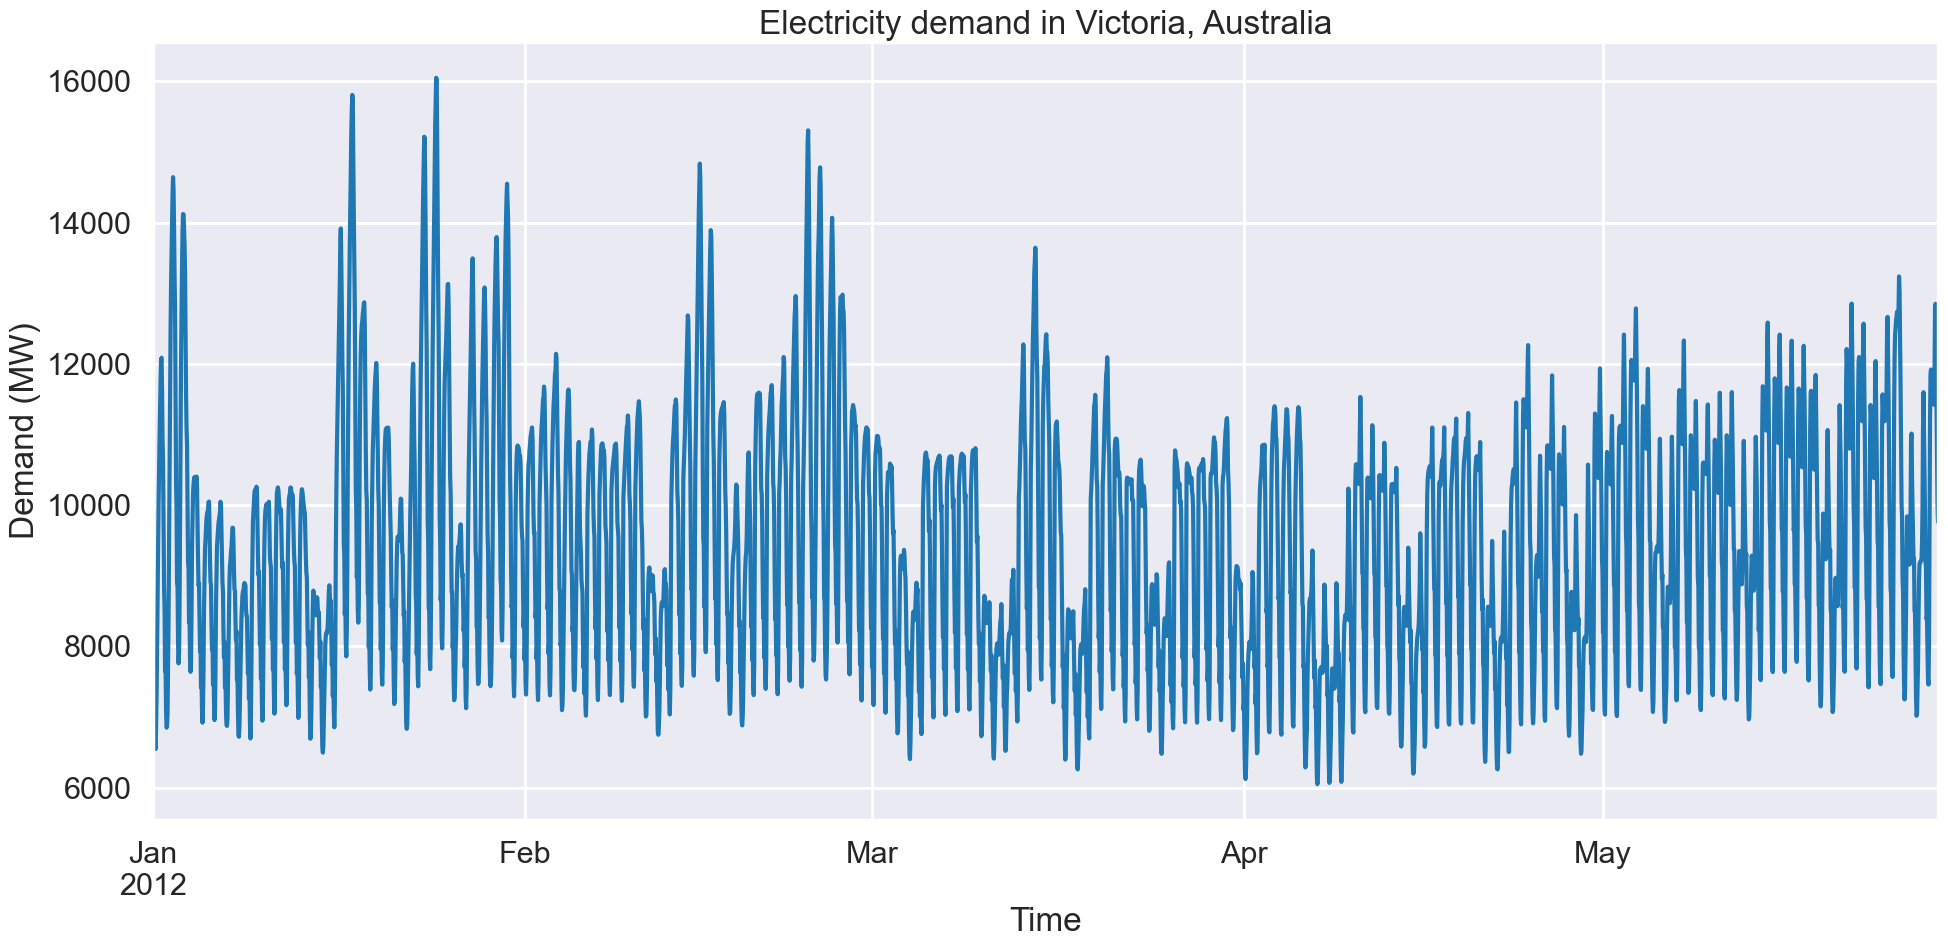

In [6]:
# Plot the time series
ax = timeseries.plot(y="demand", figsize=[20, 10], legend=False)
ax.set_ylabel("Demand (MW)")
ax.set_xlabel("Time")
ax.set_title("Electricity demand in Victoria, Australia")
plt.tight_layout()

We expect there to be a daily seasonality associated with electricity demand. Let’s confirm this by plotting the hourly demand for each day and segregating it by month.

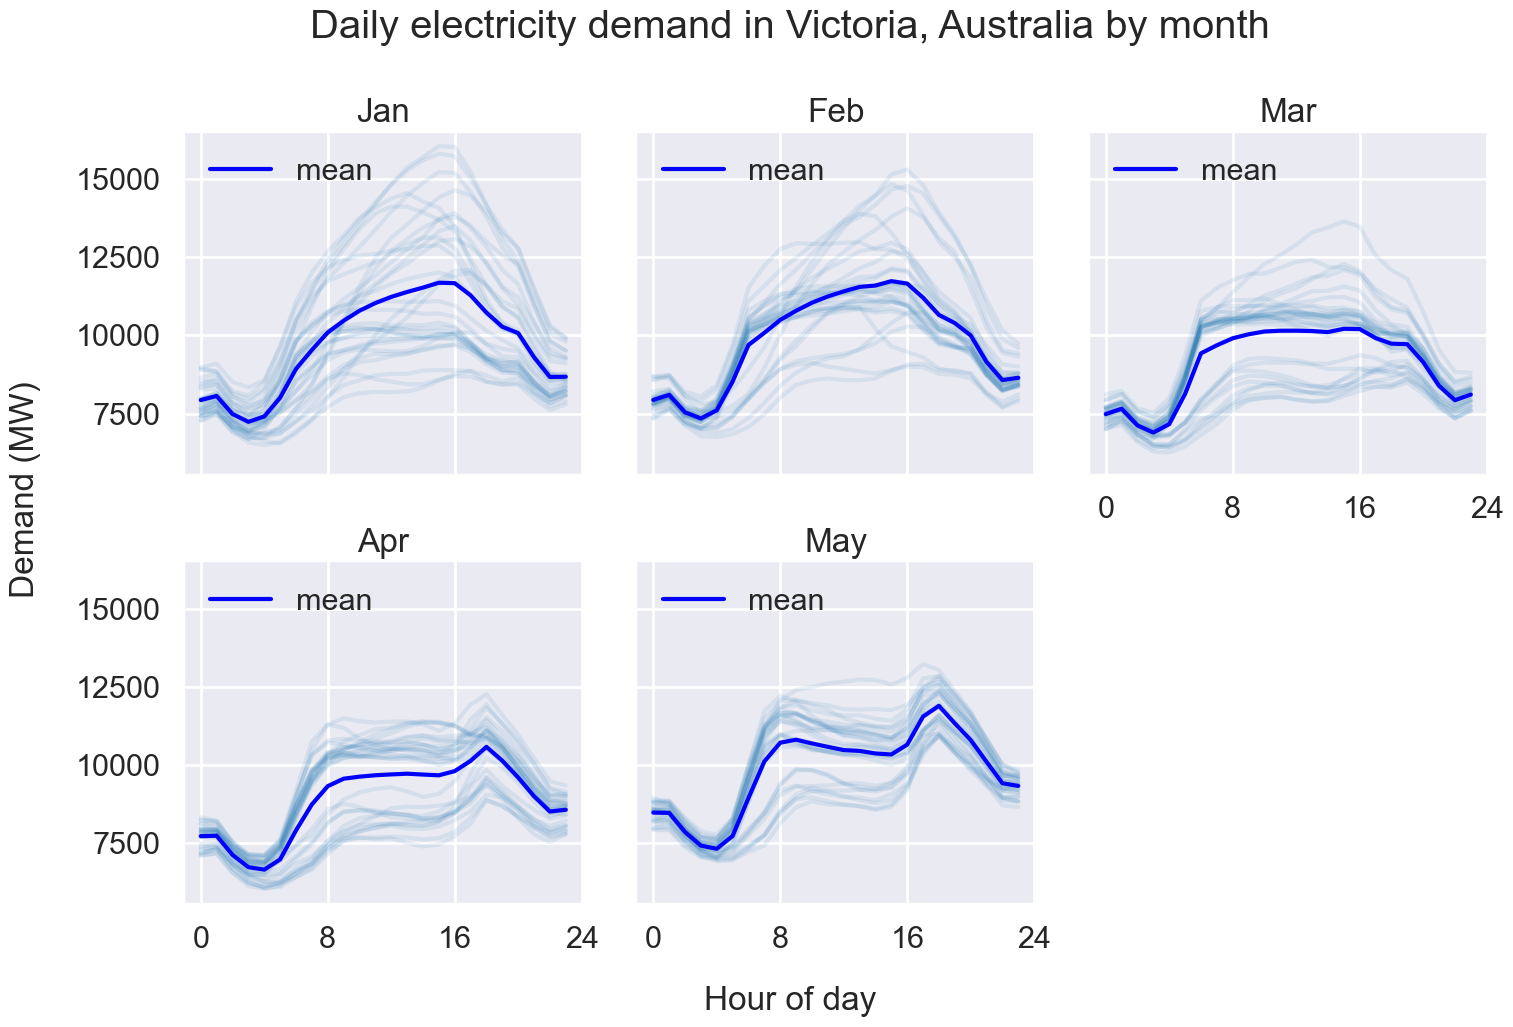

In [7]:
# Plot the electricity demand for each day in each month
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[15, 10], sharey=True)
ax = ax.flatten()

sns_blue = sns.color_palette(as_cmap=True)[0] # Get seaborn blue color
MONTHS = ["Jan", "Feb", "Mar", "Apr", "May"]

### Iterate over each month
for ix, month in enumerate(MONTHS): 

    ## Plot individual time series for each day 
    
    daily_ts = []
    
    ### Loop over the demand for each day in a given month
    for _, ts in ( 
        timeseries[["demand", "day_of_month", "month"]]
        .query(f"month == {ix+1}") # Filter timeseries to a single month
        .groupby("day_of_month") 
    ):
        ts = ts.reset_index()
        daily_ts.append(ts["demand"]) # Store the daily demand time series
      
        ts["demand"].plot( # Plot the time series for a single day
            alpha=0.1, ax=ax[ix], color=sns_blue, label="_no_legend_"
            )
      
        ax[ix].set_xticks(np.arange(0, len(ts) + 1, 8))
        ax[ix].set_title(month)

    # Plot average electricity demand at each hour of the day
    pd.concat(daily_ts, axis=1).mean(axis=1).plot(
        ax=ax[ix], color="blue", label="mean", legend=True
    ) # Compute average of the daily time series and plot it
    ax[ix].legend(loc="upper left", frameon=False)

    if month in ("Jan", "Feb"):
        ax[ix].tick_params(
            axis="x", which="both", bottom=False, top=False, labelbottom=False
        )

fig.text(0.5, -0.02, "Hour of day", ha="center")
fig.text(-0.02, 0.5, "Demand (MW)", va="center", rotation="vertical")
fig.suptitle("Daily electricity demand in Victoria, Australia by month")
fig.delaxes(ax[-1])
fig.tight_layout()

We see that there is daily seasonality. We can also see the daily seasonality change in time. In the summer months (e.g., January) there is a daily peak around 4 PM whereas in the winter months (e.g., May) there are now two peaks, one around 8 AM and another around 6 PM. 

Now let’s plot the data to look at weekly seasonality.


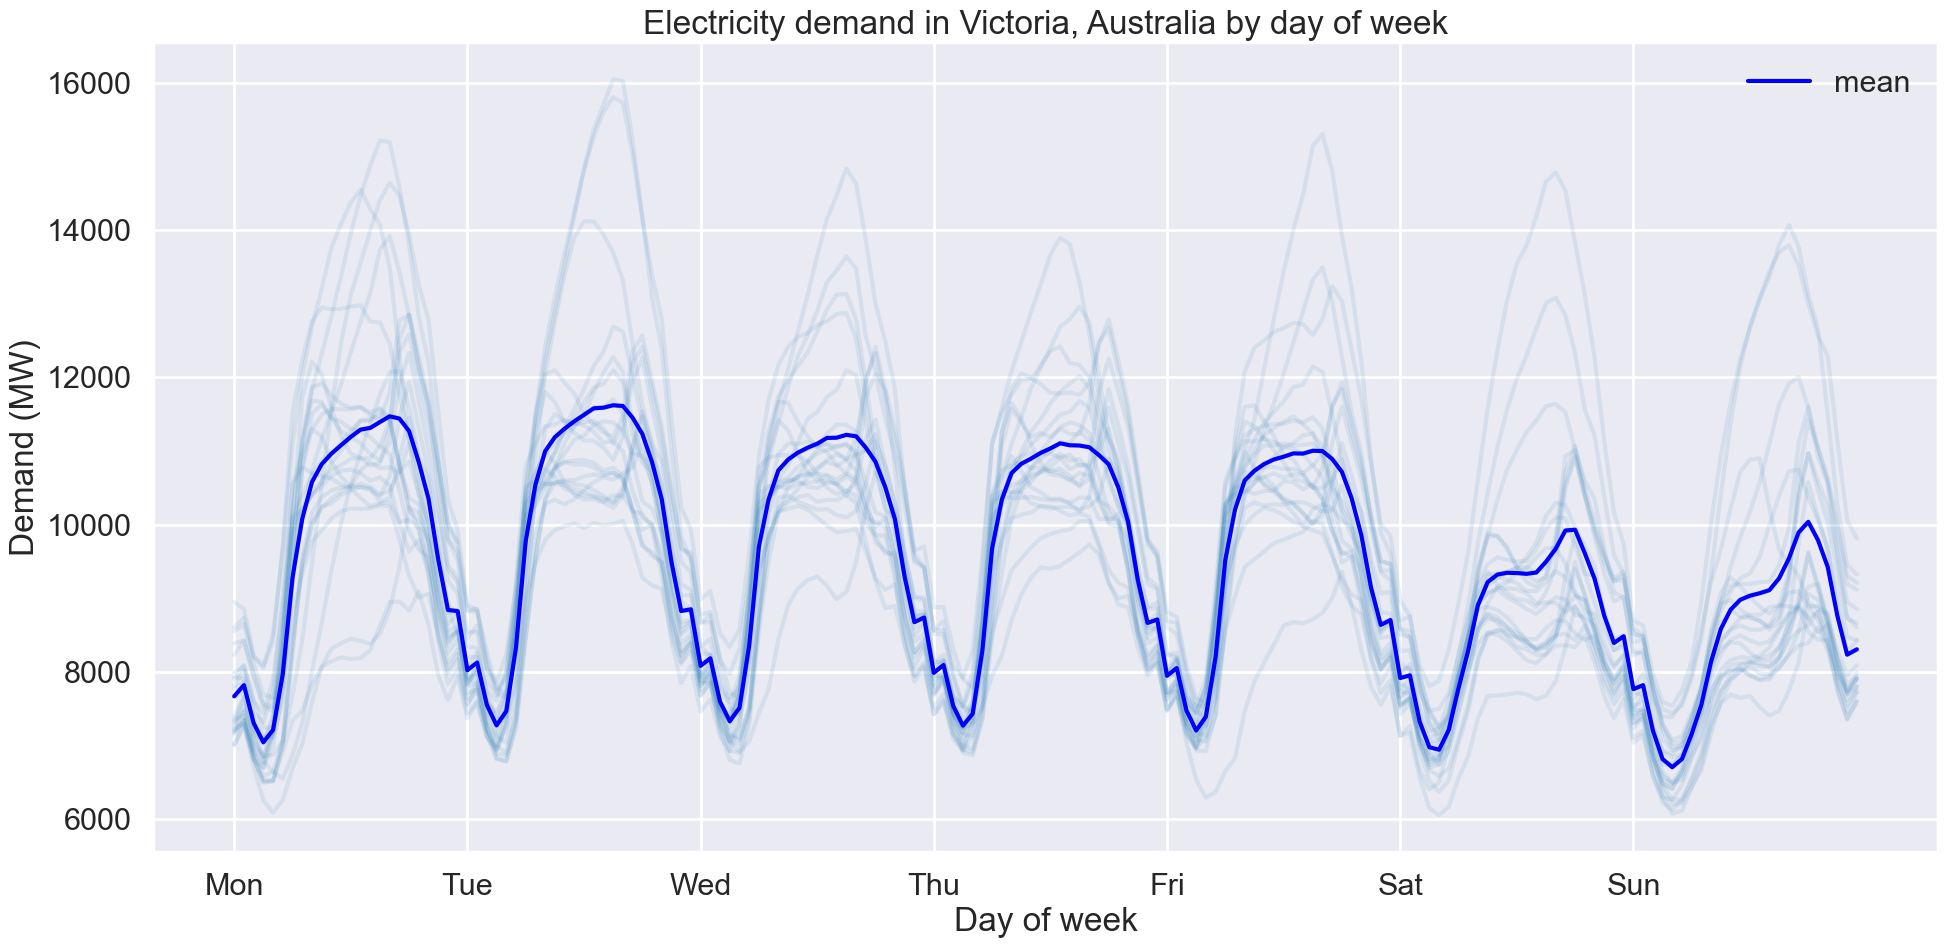

In [8]:
fig, ax = plt.subplots(figsize=[20, 10])

weekly_ts = []
sns_blue = sns.color_palette(as_cmap=True)
DAYS = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

## Iterate over each week
for week, ts in timeseries.groupby("week"):
    ts = ts.reset_index()
    weekly_ts.append(ts["demand"]) # Store the weekly time series 
    ts["demand"].plot( # Plot the weekly time series
        alpha=0.1, ax=ax, label="_no_legend_", color=sns_blue)
    plt.xticks(ticks=np.arange(0, 167, 24), labels=DAYS)

pd.concat(weekly_ts, axis=1).mean(axis=1).plot( # Compute average over all weeks and plot average
    ax=ax, color="blue", label="mean", legend=True
)

ax.set_ylabel("Demand (MW)")
ax.set_title("Electricity demand in Victoria, Australia by day of week")
ax.set_xlabel("Day of week")
ax.legend(loc="upper right", frameon=False)

plt.tight_layout()

We see that there is weekly seasonality, that is, there is less demand on weekends than on weekdays.

# Apply MSTL to the electricity demand dataset

The key inputs into `MSTL` are:

* `periods` - The period of each seasonal component (e.g., for hourly data with daily and weekly seasonality we would have: `periods=(24, 24*7)`.
* `windows` - The lengths of each seasonal smoother with respect to each period. If these are large then the seasonal component will show less variability over time. Must be odd. If `None` a set of default values determined by experiments conducted in [1] are selected.
* `lmbda` - The lambda parameter for a Box-Cox transformation prior to decomposition. If `None` then no transformation is done. If `"auto"` then an appropriate value for lambda is automatically selected from the data.
* `iterate` - Number of iterations to use to refine the seasonal component.
* `stl_kwargs` - All the other parameters which can be passed to STL (e.g., `robust`, `seasonal_deg`, etc.). See [STL docs](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.STL.html).
    
Note: there are some key differences in this implementation to [[1]](https://arxiv.org/pdf/2107.13462.pdf). Missing data must be handled outside of the `MSTL` class. The algorithm proposed in the paper handles a case when there is no seasonality. This implementation assumes that there is at least one seasonal component.

In [24]:
mstl = MSTL(
    timeseries["demand"], # the original time series data
    periods=(24, 24 * 7), # the periods we want to decompose (seasional compononts) 
    stl_kwargs={"seasonal_deg": 0} # degrees of polynomial
)
res = mstl.fit() # than fit it

The trend component, multiple seasonal components, and residual component can be accessed from the `trend`, `seasonal`, and `resid` attributes:

In [25]:
## the trand
res.trend.head()

date_time
2012-01-01 00:00:00    10375.731736
2012-01-01 01:00:00    10365.259614
2012-01-01 02:00:00    10354.790969
2012-01-01 03:00:00    10344.325971
2012-01-01 04:00:00    10333.864811
Name: trend, dtype: float64

In [26]:
## seasional components 
# we have two (day = 24h, week = 168h)
res.seasonal.head()

,seasonal_24,seasonal_168
date_time,,
2012-01-01 00:00:00,-1694.799788,-165.282860
2012-01-01 01:00:00,-1602.267142,-231.770996
2012-01-01 02:00:00,-2205.330138,-260.793169
2012-01-01 03:00:00,-2455.880584,-387.594018
2012-01-01 04:00:00,-2372.200885,-656.522701


In [27]:
## residuals
res.resid.head()

date_time
2012-01-01 00:00:00   -589.119712
2012-01-01 01:00:00   -629.394486
2012-01-01 02:00:00   -632.946312
2012-01-01 03:00:00   -708.348017
2012-01-01 04:00:00   -669.156765
Name: resid, dtype: float64

## Plot the MSTL decomposition

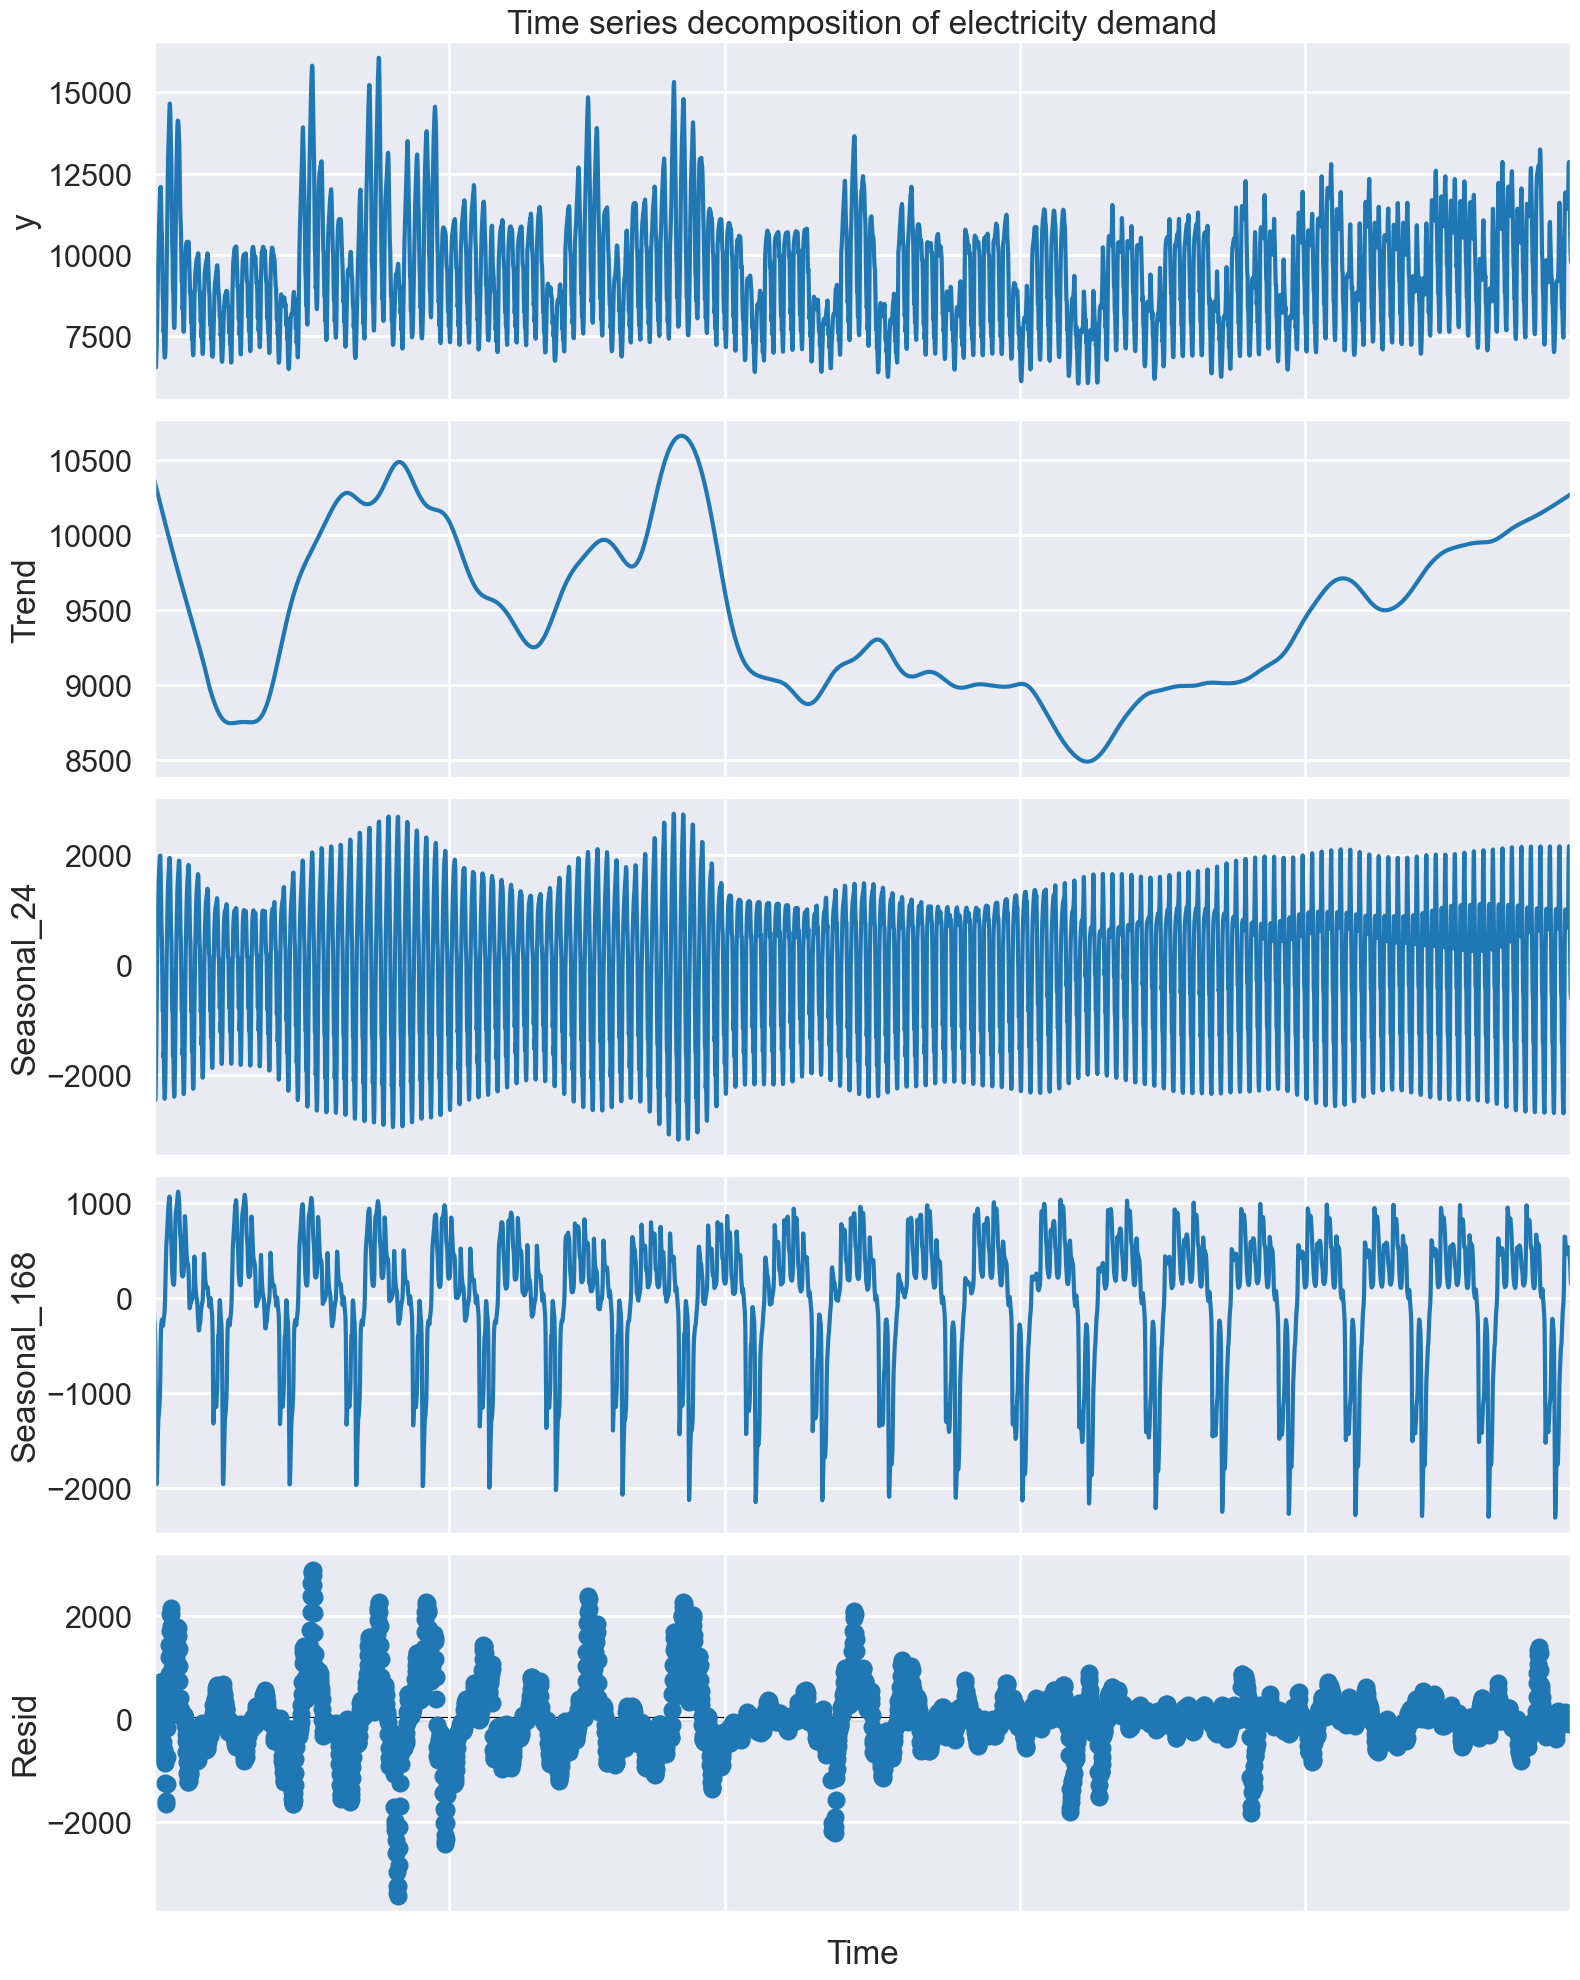

In [28]:
# Start with the plot from the results object `res`
plt.rc("figure", figsize=(16, 20))
plt.rc("font", size=13)
fig = res.plot()

# Make plot pretty
axs = fig.get_axes()

ax_last = axs[-1]
ax_last.xaxis.set_ticks(pd.date_range(start="2012-01-01", freq="MS", periods=5))
plt.setp(ax_last.get_xticklabels(), rotation=0, horizontalalignment="center")

for ax in axs[:-1]:
    ax.get_shared_x_axes().joined(ax, ax_last)
    ax.xaxis.set_ticks(pd.date_range(start="2012-01-01", freq="MS", periods=5))
    ax.set_xticklabels([])

axs[0].set_ylabel("y")
axs[0].set_title("Time series decomposition of electricity demand")
ax_last.set_xlabel("Time")

plt.tight_layout()

Let's inspect the seasonal components in a bit more detail and look at the first few days and weeks to examine the daily and weekly seasonality. 

We start with daily seasonality. One of the advantages of MSTL is that is allows us to capture seasonality which changes over time. We saw above that the daily seasonality is different in the summer and winter. So let's look at the daily seasonality from MSTL during January and May.

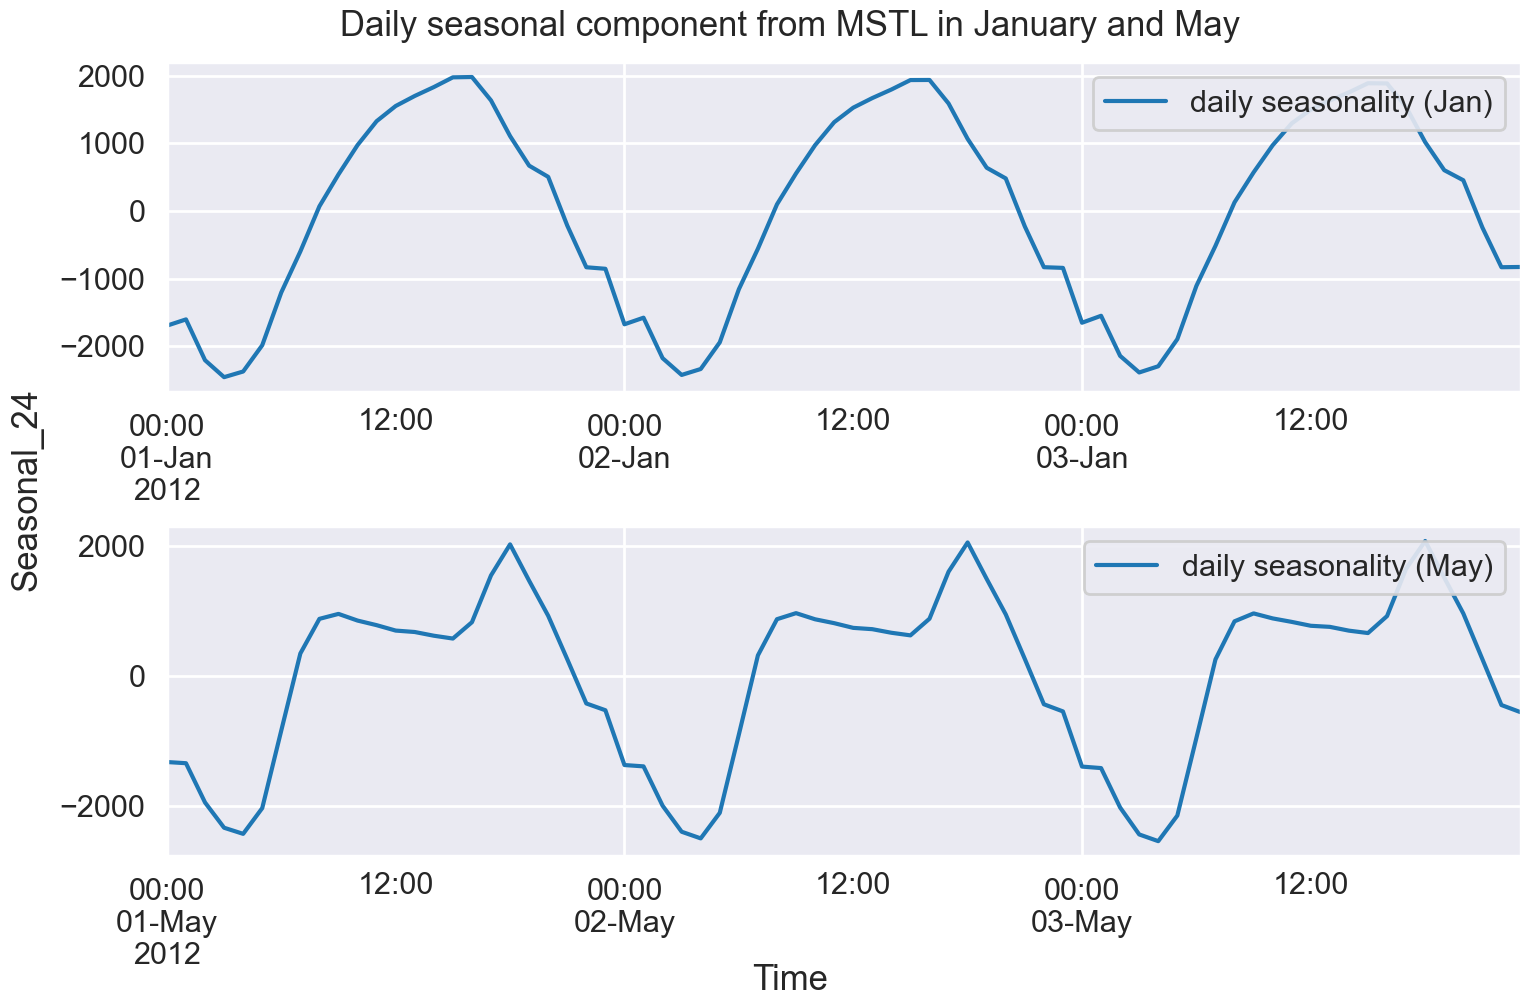

In [14]:
fig, ax = plt.subplots(nrows=2, figsize=[15, 10])
ax = ax.flatten()

# Plot daily seasonality in January
res.seasonal["seasonal_24"].iloc[: 24 * 3].plot(
    ax=ax[0], label="daily seasonality (Jan)", legend=True
)
ax[0].set_ylabel(None)
ax[0].set_xlabel(None)
ax[0].legend(loc="upper right", framealpha=0.9)

# Plot daily seasonality in May
mask = res.seasonal.index.month == 5
res.seasonal[mask]["seasonal_24"].iloc[: 24 * 3].plot(
    ax=ax[1], label="daily seasonality (May)", legend=True
)
ax[1].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].legend(loc="upper right", framealpha=0.9)

# Figure labels
fig.suptitle("Daily seasonal component from MSTL in January and May", fontsize=25)
fig.text(0.5, 0, "Time", ha="center", fontsize=25)
fig.text(-0.02, 0.5, "Seasonal_24", va="center", rotation="vertical", fontsize=25)

plt.tight_layout()

We can see that the daily seasonality of electricity demand is well captured by MSTL. We see a single peak in January and two peaks in May.

We saw previously that weekends and weekdays have different demand. Let's see if this is picked up in the weekly seasonality.

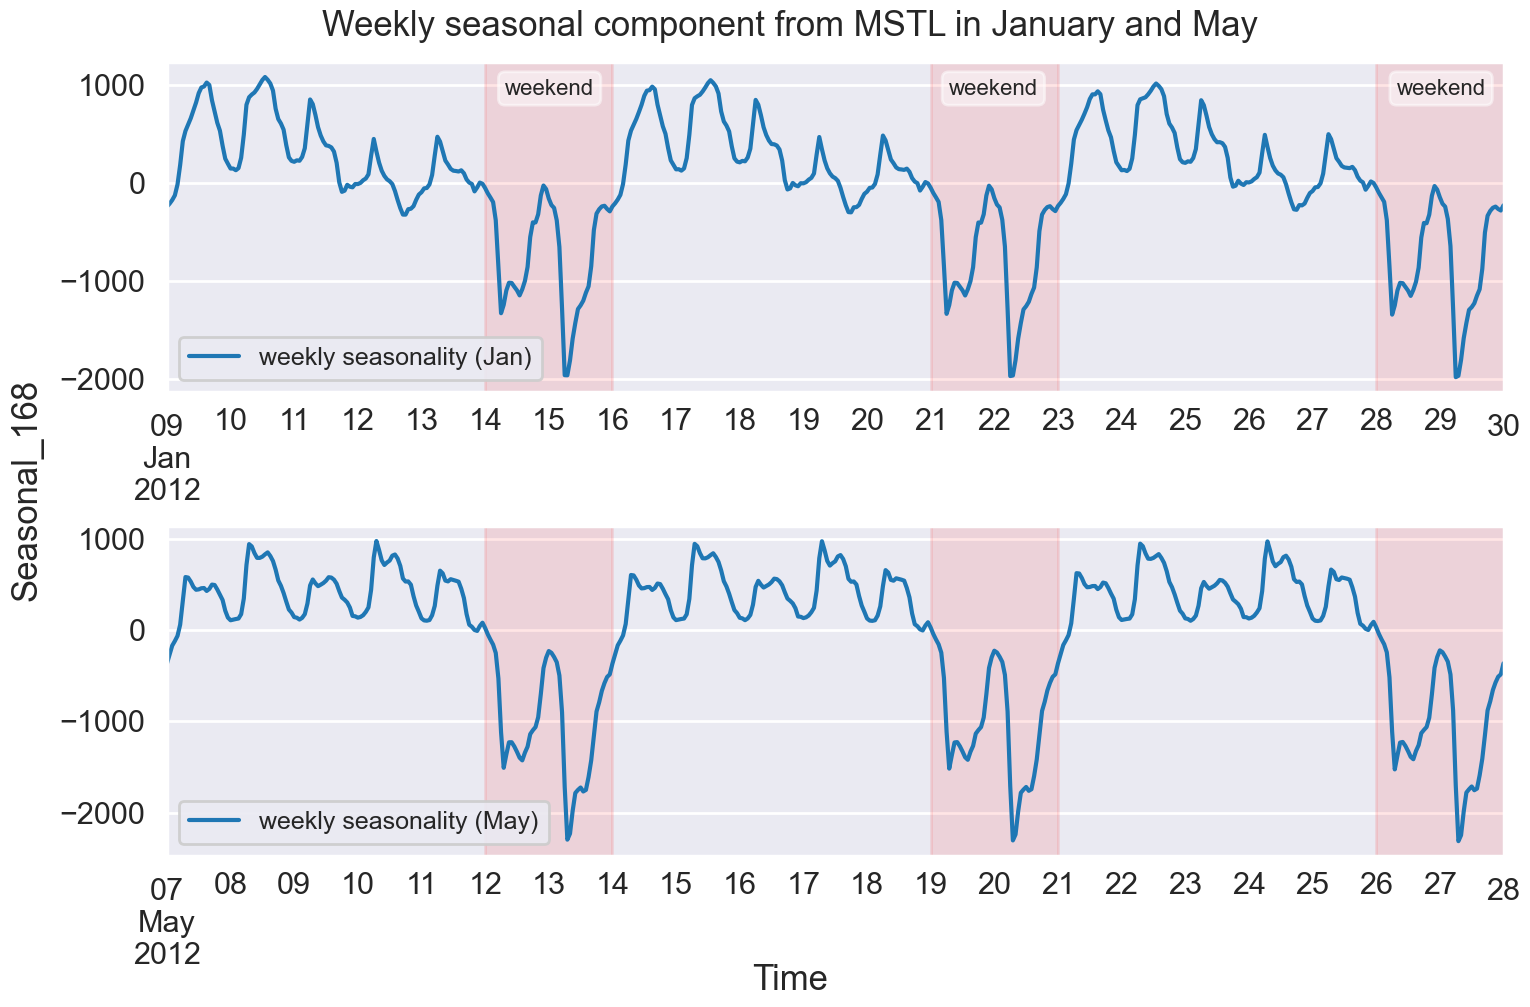

In [15]:
fig, ax = plt.subplots(nrows=2, figsize=[15, 10])
ax = ax.flatten()

# Plot weekly seasonality in January
start = pd.Timestamp("2012-01-09")  # Monday
end = start + pd.Timedelta("3W")
res.seasonal["seasonal_168"].loc[start:end].plot(
    ax=ax[0], label="weekly seasonality (Jan)", legend=True
)
ax[0].set_ylabel("seasonal_168")
ax[0].set_xlabel(None)
ax[0].set_ylabel(None)
ax[0].legend(loc="lower left", framealpha=0.9, fontsize=18)

props = dict(boxstyle="round", facecolor="white", alpha=0.5)
ax[0].text(
    0.253,
    0.95,
    "weekend",
    transform=ax[0].transAxes,
    fontsize=16,
    verticalalignment="top",
    bbox=props,
)

props = dict(boxstyle="round", facecolor="white", alpha=0.5)
ax[0].text(
    0.585,
    0.95,
    "weekend",
    transform=ax[0].transAxes,
    fontsize=16,
    verticalalignment="top",
    bbox=props,
)

props = dict(boxstyle="round", facecolor="white", alpha=0.5)
ax[0].text(
    0.92,
    0.95,
    "weekend",
    transform=ax[0].transAxes,
    fontsize=16,
    verticalalignment="top",
    bbox=props,
)

weekends = [
    ("2012-01-14", "2012-01-16"),
    ("2012-01-21", "2012-01-23"),
    ("2012-01-28", "2012-01-30"),
]
for start_, end_ in weekends:
    ax[0].axvspan(start_, end_, alpha=0.1, color="red")

# Plot weekly seasonality in May
mask = res.seasonal.index.month == 5
start = pd.Timestamp("2012-05-7")
end = start + pd.Timedelta("3W")
res.seasonal[mask]["seasonal_168"].loc[start:end].plot(
    ax=ax[1], label="weekly seasonality (May)", legend=True
)
ax[1].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].legend(loc="lower left", framealpha=0.9, fontsize=18)

weekends = [
    ("2012-05-12", "2012-05-14"),
    ("2012-05-19", "2012-05-21"),
    ("2012-05-26", "2012-05-28"),
]
for start_, end_ in weekends:
    ax[1].axvspan(start_, end_, alpha=0.1, color="red")

# Figure labels
fig.suptitle("Weekly seasonal component from MSTL in January and May", fontsize=25)
fig.text(0.5, 0, "Time", ha="center", fontsize=25)
fig.text(-0.02, 0.5, "Seasonal_168", va="center", rotation="vertical", fontsize=25)

plt.tight_layout()

For the weekly seasonality extracted by MSTL we can see that there is less usage during the weekends as expected. That pattern is stable over the year and we see it in both January and May.

And that's it! Using MSTL we can perform time series decompostion on a multi-seasonal time series!